# Train without normalize

This notebook will use the KuHar (train) and Motionsense (test) and will:

1. Apply DFT over dataset windows
2. Train ten times with RF, SVM and KNN, and take the average accuracy and f1-score


In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import KuHar_BalancedView20HzMotionSenseEquivalent
from librep.datasets.har.loaders import MotionSense_BalancedView20HZ
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-14 19:23:06.090285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 19:23:06.090305: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load KuHar, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = KuHar_BalancedView20HzMotionSenseEquivalent("../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", download=False)
train_kuhar = loader.load(concat_all=True)

In [4]:
train_kuhar.window_names, train_kuhar.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [5]:
# Checking the whole data...
train_kuhar[:][0]

array([[-1.04282825,  7.06961015,  3.45567162, ...,  0.50890319,
        -0.11305444, -0.38018973],
       [-2.43790048, -2.62844861, -2.16686063, ..., -0.09413675,
        -0.23829967,  0.3772596 ],
       [-0.66433712,  0.48346468,  3.09023849, ...,  0.28845053,
         0.11892508,  0.28859494],
       ...,
       [ 2.14782272, -2.31485654, -0.81952774, ...,  0.93662894,
         0.52192419,  0.85651806],
       [-8.01534249,  2.34830125,  0.95563646, ...,  1.32309685,
        -2.0783611 , -2.05310751],
       [-2.63105618,  1.07232495, -0.86048054, ...,  1.27507948,
         0.3014468 ,  0.99273025]])

In [6]:
train_kuhar[0][0].shape

(360,)

In [7]:
# Load MotionSense and create PandasMultiModalDatasets with the correct pre-defined windows
loader = MotionSense_BalancedView20HZ("../../data/views/MotionSense/balanced_20Hz_9.81_acc", download=False)
test_motionsense = loader.load(concat_all=True)

In [8]:
test_motionsense.window_names, test_motionsense.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [9]:
# Checking the whole data...
test_motionsense[:][0]

array([[-0.99650627, -2.17149377, -2.2956927 , ...,  0.29260805,
         0.932535  ,  0.78214699],
       [-0.8095929 ,  1.97314556, -0.17077249, ...,  0.71842028,
         0.33650671,  0.93656304],
       [ 1.06264784, -0.45067886,  0.17079374, ...,  0.66747733,
        -0.0253858 , -0.03709332],
       ...,
       [-0.97987535, -0.60965688,  0.03467323, ..., -0.02418191,
        -0.26655296, -0.81136345],
       [ 2.74807307,  3.85601241, -2.25153468, ...,  0.2010255 ,
        -0.37453148,  0.13791192],
       [ 1.77504141,  1.96173366,  2.42468801, ..., -0.1108572 ,
         0.10921315,  0.77653174]])

In [10]:
# 1. Perform standard scaler in train dataset
#train_scaler = StandardScaler()
#train_scaler.fit(train_val[:][0])
# OK Standard scaler was fit over train dataset.

Let's create the transforms. In general (by default) transforms are applyied over each window of the dataset, separadetly. We can control how transform will be applyied using Wrapping the transform arround `WindowedTransform`. 

The `WindowedTransform` receives, as argument to the constructor:

- The transform to be wrapped
- `fit_on`: can be "all" (apply fit over the whole dataset), "window" (apply fit over each window) or None (does not do fit).
- `transform_on`: can be "all" (apply transform over the whole dataset) or "window" (apply transform over each window)


One transformers will be created:

- `fft_transform`: Apply the transforms over windows of the dataset

In [11]:
# Create the objects
#scaler_transform = WindowedTransform(
#    transform=train_scaler, fit_on=None, transform_on="all")

fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[#scaler_transform,
                fft_transform], new_window_name_prefix="scaled."
)

In [12]:
# Transform it and generate a new dataset!
train_kuhar_fft = transformer(train_kuhar)
test_motionsense_fft = transformer(test_motionsense)

In [13]:
# Checking the whole data...
train_kuhar_fft[:][0]

array([[ 5.02447148,  1.61251322,  6.76232259, ...,  1.62531257,
         3.00380672,  1.71698001],
       [ 3.57299732, 10.83009996, 11.81552738, ...,  1.2580665 ,
         0.92633676,  0.35502988],
       [18.92428589, 22.85409918, 26.51434407, ...,  1.86459895,
         0.75637642,  1.45070104],
       ...,
       [43.69389496,  8.74800806, 37.89147291, ...,  6.4816757 ,
         4.13248443,  2.53251507],
       [32.54270782, 15.65827347, 17.03885586, ...,  3.64473191,
         6.50781902,  2.37357152],
       [34.1888772 , 33.79995516, 32.25975081, ...,  8.15273054,
         8.17883539,  1.62408925]])

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [14]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    normalize='true'
)

### RandomForest

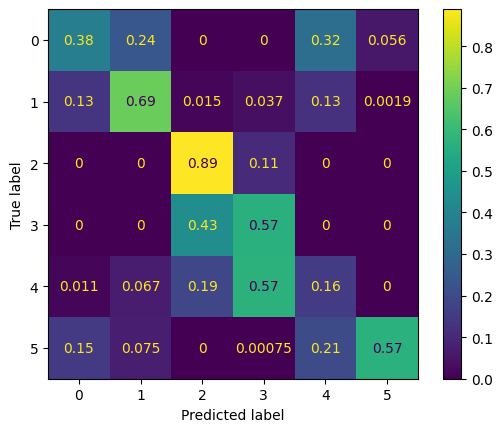

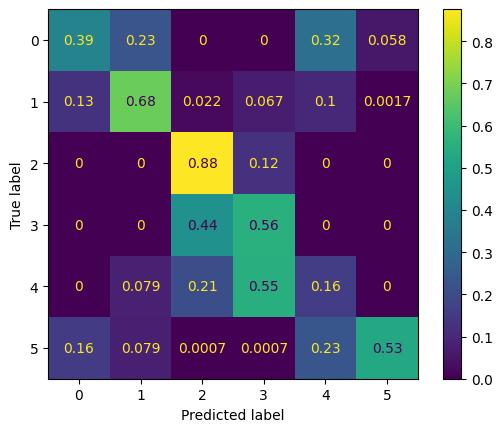

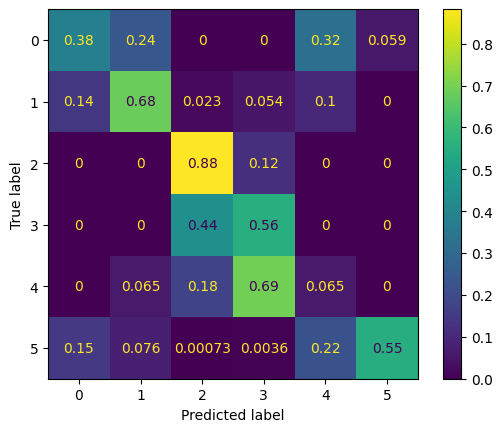

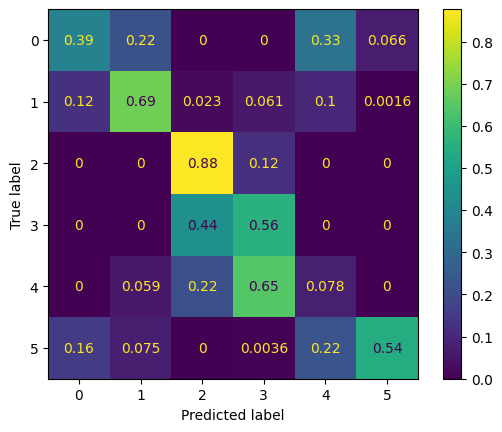

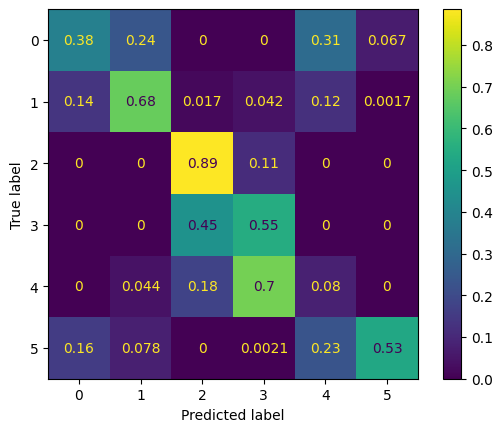

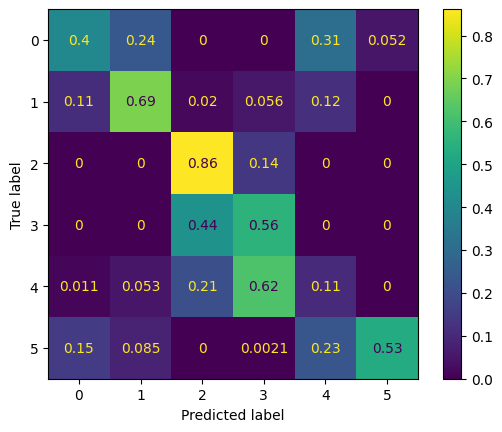

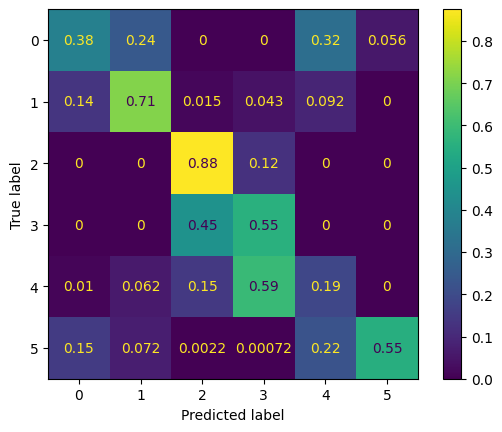

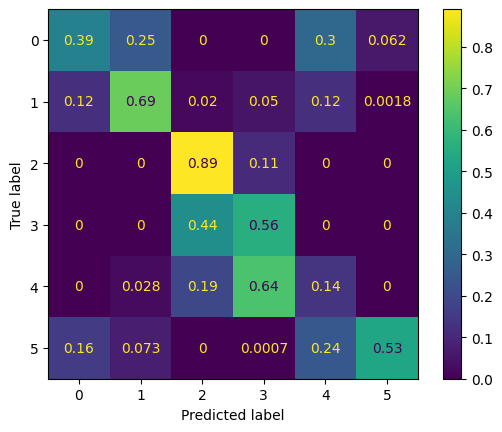

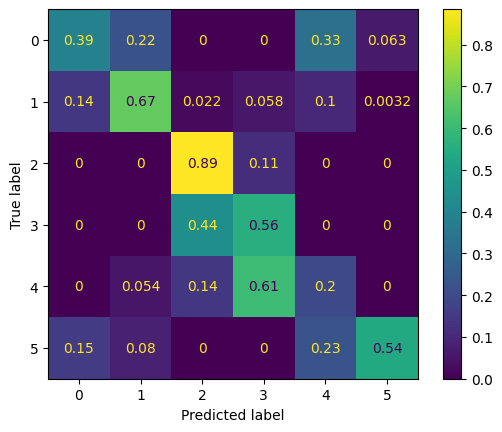

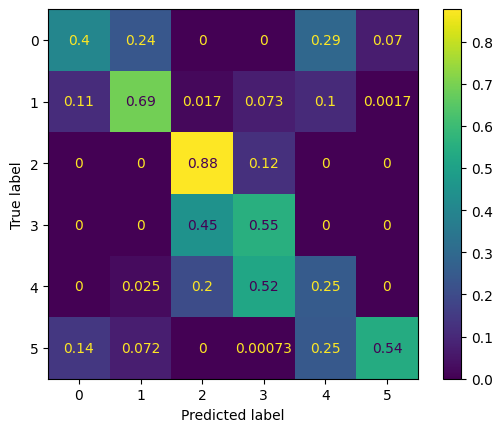

Mean accuracy (10 runs): 0.5305. Mean f1-score: 0.5867
Standard deviation accuracy (10 runs): 0.0041. Standard deviation f1-score: 0.0053


In [15]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_kuhar_fft, [test_motionsense_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

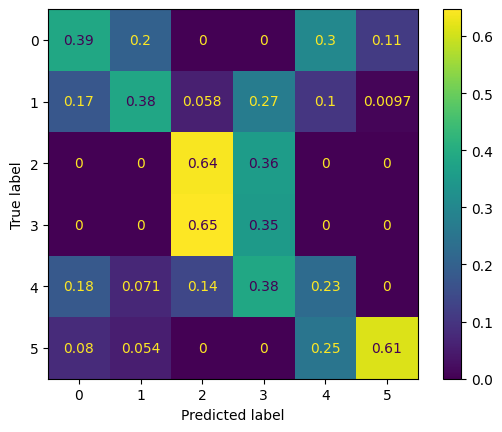

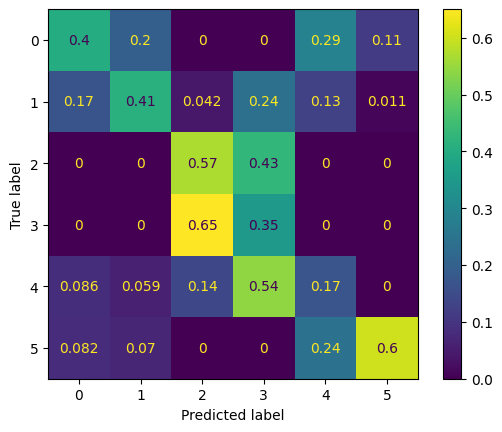

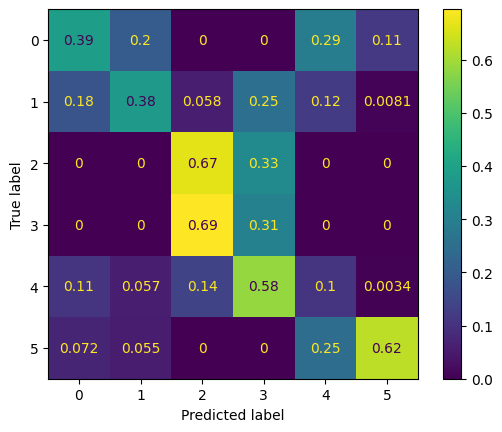

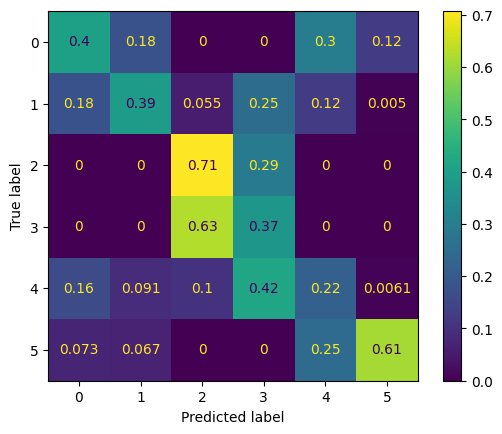

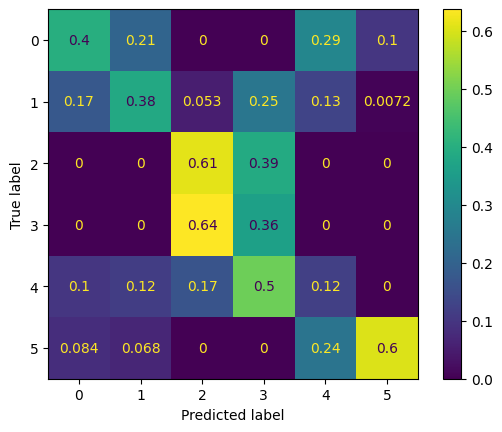

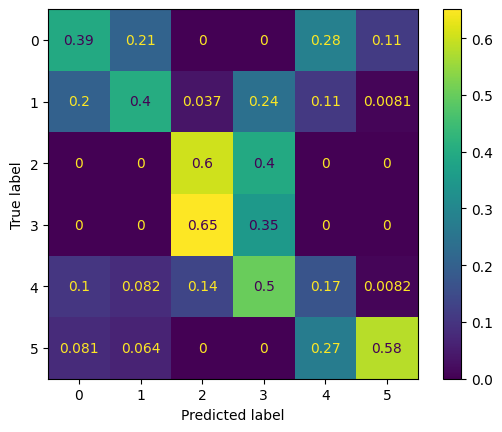

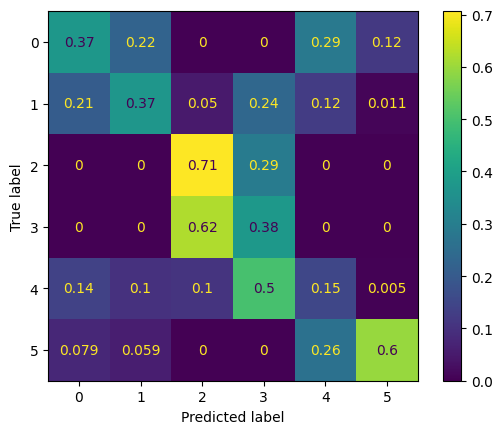

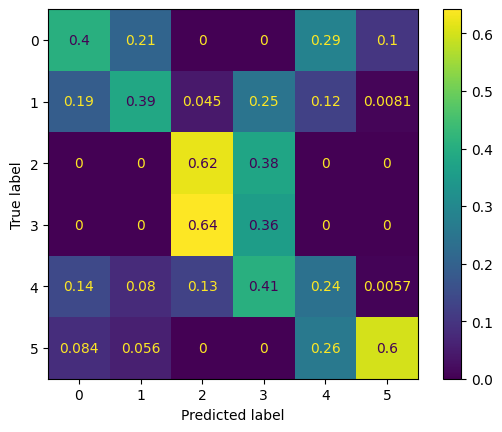

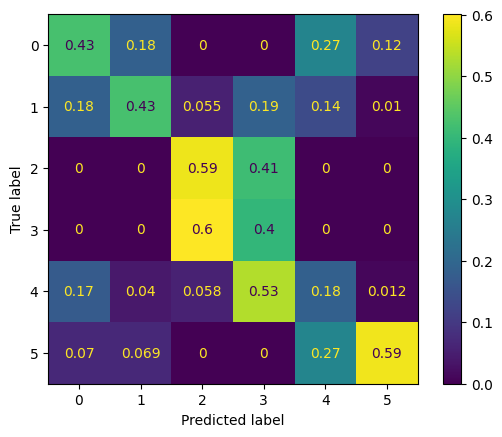

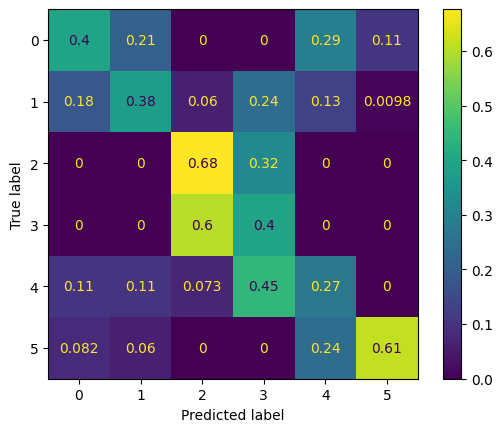

Mean accuracy (10 runs): 0.4370. Mean f1-score: 0.4825
Standard deviation accuracy (10 runs): 0.0110. Standard deviation f1-score: 0.0124


In [16]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_kuhar, [test_motionsense])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### SVM

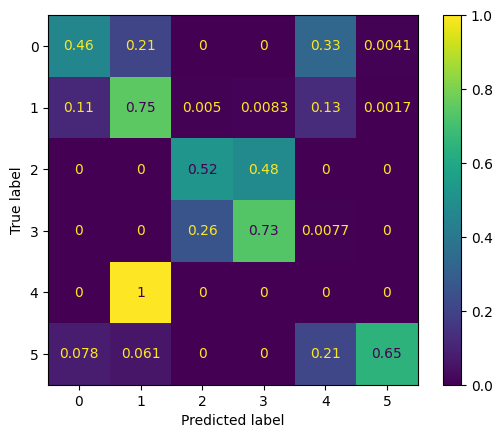

Mean accuracy (1 runs): 0.5669. Mean f1-score: 0.6567
Standard deviation accuracy (1 runs): 0.0000. Standard deviation f1-score: 0.0000


In [17]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_kuhar_fft, [test_motionsense_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (1 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

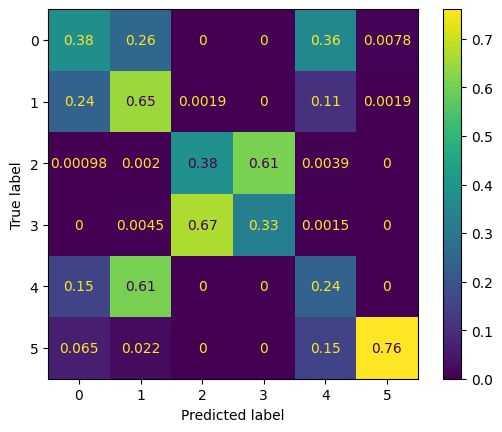

Mean accuracy (1 runs): 0.4808. Mean f1-score: 0.5274
Standard deviation accuracy (1 runs): 0.0000. Standard deviation f1-score: 0.0000


In [18]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_kuhar, [test_motionsense])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (1 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### KNN

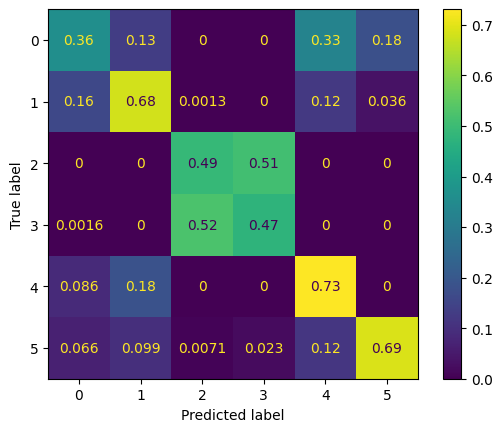

Mean accuracy (1 runs): 0.5024. Mean f1-score: 0.5278
Standard deviation accuracy (1 runs): 0.0000. Standard deviation f1-score: 0.0000


In [19]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_kuhar_fft, [test_motionsense_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (1 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

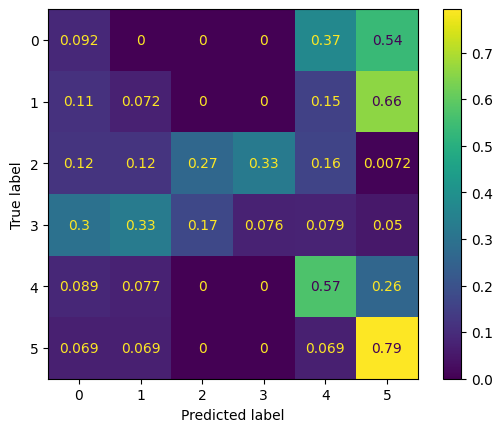

Mean accuracy (1 runs): 0.1976. Mean f1-score: 0.2353
Standard deviation accuracy (1 runs): 0.0000. Standard deviation f1-score: 0.0000


In [20]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_kuhar, [test_motionsense])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (1 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")